In [1]:
from nptdms import TdmsFile
from sklearn import preprocessing 
import pandas as pd
import numpy as np
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from collections import defaultdict
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
import seglearn as sgl
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

In [2]:
# load in data
tdms_file = TdmsFile(".\\FW-1-1\\AKF-FW1-1-H521-1000.tdms")
#list out the groups
groups = tdms_file.groups()  
groups

['BOOL', 'INT', 'DINT', 'UINT', 'USINT', 'TIME']

**explain** We now consider the situation where we have a number of time series and  wish toexplore the relations between them. We rst look at the relation between crosscorrelation and multivariate autoregressive models and then at the cross-spectral density and coherence.


In [3]:
# Step 1: kick out the "all zero", "all one" value
df = tdms_file.object('DINT').as_dataframe()
num_attr = df.columns.size
dropall = []
for i in range(0,num_attr):
    index = df.columns[i]
    if(all(df[index]==0) or all(df[index]==1)):
        dropall.append(df.columns[i])
df.drop(dropall, axis = 1, inplace= True)

In [23]:
df_power = df['SupplyUnit 50U4 (Unidrive M701 Regen).Transmit PDO Mapping 8.Leistung']
# sliding window method
df_seg = []
size_df = df_power.size
anchor = 1 
width = 965
while(anchor+width*2 < size_df): 
    mid = df_power[anchor+1:anchor+width*2].idxmax()
    seg = df_power[mid-width: mid+width]
    df_seg.append(seg)
    anchor = mid

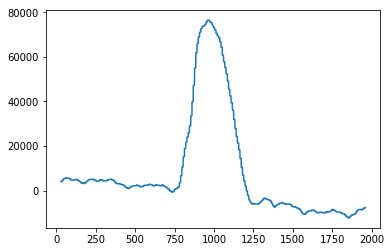

In [27]:
df_seg[29].plot()

In [21]:
df['SupplyUnit 50U4 (Unidrive M701 Regen).Transmit PDO Mapping 8.Leistung'].head(2000).idxmax()


965

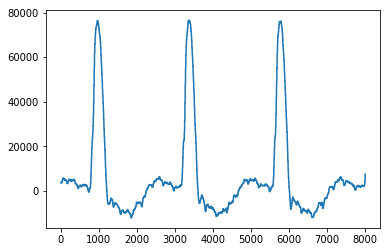

In [18]:
df['SupplyUnit 50U4 (Unidrive M701 Regen).Transmit PDO Mapping 8.Leistung'].head(8000).plot()

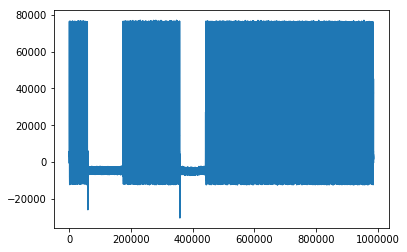

In [55]:
df['SupplyUnit 50U4 (Unidrive M701 Regen).Transmit PDO Mapping 8.Leistung'].plot()

# Time Series Segmentation through Automatic Feature Learning


In [ ]:
# The method derives from https://arxiv.org/pdf/1801.05394.pdf
W, b_e, b_d, Wx  = np.randomly